## Assignment 2, Natural Language Processing, Group 14

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/krzysztof99xd/A2-14.git

fatal: destination path 'A2-14' already exists and is not an empty directory.


In [ ]:
%cd A2-14

/content/A2-14


In [ ]:
!pip install -r requirements.txt

# Pre-processing

## Filter corpus

In [ ]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
#nltk.download('stopwords')
import re
import random
random.seed(45)

# Load and filter the data
news_df = pd.read_csv('us_equities_news_dataset.csv')
news_df = news_df.drop(columns=['article_id', 'url', 'category', 'release_date', 'provider'])
news_df = news_df.dropna(subset=['content'])
news_df['content'] = news_df['content'].astype(str)


# Filter for articles mentioning 'Nvidia' or 'NVDA' in the ticker, title, or content
pattern_nvidia = r'\b(?:Nvidia|NVDA)\b'
nvidia_mentioned_articles = news_df[
    (news_df['ticker'] == 'NVDA') |
    news_df['title'].str.contains(pattern_nvidia, case=False, na=False) |
    news_df['content'].str.contains(pattern_nvidia, case=False, na=False)
]

# Save and reload filtered articles to avoid duplicate content
filtered_corpus = nvidia_mentioned_articles.copy()
filtered_corpus.to_csv('filtered_corpus.csv', index=False)

print('Filtered corpus dimensions:', filtered_corpus.shape)

## Clean and tokenize filtered corpus

In [ ]:
import pandas as pd
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
import re

news_df = pd.read_csv('filtered_corpus.csv')

# Set up stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess and tokenize text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove leading and trailing whitespace
    text = text.strip()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = text.split()
    # Remove 1-letter words and stopwords
    tokens = [token for token in tokens if len(token) > 1 and token not in stop_words]
    return tokens

# Apply the function to the content column and create a new 'tokens' column
news_df['tokens'] = news_df['content'].apply(preprocess_text)

# Remove duplicates based on the 'tokens' column
df = news_df.drop_duplicates(subset=['tokens'])
print('Filtered corpus dimensions:', df.shape)
print(df[['content', 'tokens']].head(10))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Filtered corpus dimensions: (3306, 5)
                                             content  \
0  ECB Effects\nThe move in the euro was huge  fa...   
1  6 Stocks To Watch  March 6 Trading Session\nSt...   
2  Investing com   A rout in Apple and Facebook  ...   
3  For Immediate ReleaseChicago  IL   January 13 ...   
4  With 4 500 companies bringing their innovation...   
5  With 4 500 companies bringing their innovation...   
6  When trading opened in 2019  investors were ju...   
7  Excitement is building up for the 2020 Summer ...   
8  For Immediate ReleaseChicago  IL   December 3 ...   
9  For Immediate ReleaseChicago  IL   November 26...   

                                              tokens  
0  [ecb, effects, move, euro, huge, falling, pips...  
1  [stocks, watch, march, trading, session, stock...  
2  [investing, com, rout, apple, facebook, nasdaq...  
3  [immediate, releasechicago, il, january, zacks...  
4  [companies, bringing, innovations, ces, jan, g...  
5  [companies, 

In [ ]:
# Function to convert the tokenized column to a list of lists (flatten list)
def make_list_of_lists(data_frame, column_name):
    data = data_frame[column_name].tolist()
    return data

# Create the list of lists for modeling
data = make_list_of_lists(df, 'tokens')
print(len(data))

3306


## top-n% bottom-n% removal

In [ ]:
from collections import Counter
def remove_n_percent(processed_text, n=0):
    if n > 0:
        word_freq = Counter([word for doc in processed_text for word in doc])
        top_n = set([word for word, _ in word_freq.most_common(int(n/100*len(word_freq)))])
        bottom_n = set([word for word, _ in word_freq.most_common()[:-int(n/100*len(word_freq))-1:-1]])
        processed_text = [[word for word in doc if word not in top_n and word not in bottom_n] for doc in
        processed_text]
    return processed_text

In [ ]:
from collections import Counter

def remove_n_percent(data, n=0):
    """
    Removes the top n% and bottom n% of the most and least frequent words from the input list of lists.

    Parameters:
    data (list of lists): The input data, where each sublist contains tokenized text.
    n (float): The percentage of the most and least common words to remove.

    Returns:
    list of lists: The input data with the top n% and bottom n% words removed.
    """
    if n <= 0 or n > 50:
        raise ValueError("n should be greater than 0 and less than or equal to 50.")

    # Flatten the list of lists to count word frequencies
    all_words = [word for sublist in data for word in sublist]
    word_freq = Counter(all_words)
    # Calculate the number of words to remove for top and bottom n%
    num_words_to_remove = int(n / 100 * len(word_freq))
    # Get the top n% most frequent words
    top_n_words = {word for word, _ in word_freq.most_common(num_words_to_remove)}
    # Get the bottom n% least frequent words
    bottom_n_words = {word for word, _ in word_freq.most_common()[:-num_words_to_remove -1:-1]}
    # Combine top and bottom n% words to be removed
    words_to_remove = top_n_words.union(bottom_n_words)
    # Filter the data to remove these words
    filtered_data = [[word for word in sublist if word not in words_to_remove] for sublist in data]
    filtered_data = [doc for doc in filtered_data if len(doc) > 0]

    return filtered_data

## Load the dataset and choose only the articles where NVIDIA word appears in the content

In [ ]:
# import pandas as pd
#
# # Load the dataset
# df = pd.read_csv('us_equities_news_dataset.csv')
#
# # Filter rows where 'content' column contains the word 'NVIDIA'
# nvidia_rows = df[df['content'].str.contains('NVIDIA', case=False, na=False)]
#
# # Display the filtered rows
# print(nvidia_rows)

## Remove unnecessary columns

In [ ]:
# # Remove the specified columns
# nvidia_rows = nvidia_rows.drop(['id', 'ticker', 'url', 'release_date'], axis=1)
#
# # Save the modified DataFrame to a new CSV file
# nvidia_rows.to_csv('nvidia_rows_news_dataset.csv', index=False)

## Preprocess the data

In [ ]:
# from nltk.tokenize import word_tokenize
# import re
# from unidecode import unidecode
# import pandas as pd
# from nltk.corpus import stopwords
# from collections import Counter
# from nltk.stem import PorterStemmer
# from nltk.stem import WordNetLemmatizer
#
# stop_words = set(stopwords.words('english'))
# stemmer = PorterStemmer()
#
# def preprocess_text(texts):
#     n=0
#     processed_texts = []
#     # lowercasing, keep text only, remove accents, tokenization
#     tokens = [word for word in word_tokenize(re.sub(r'[^a-zA-Z\s]', '', unidecode(texts.lower())))]
#     # stopword removal
#     tokens = [token for token in tokens if token not in stopwords.words('english')]
#
#     # remove short words
#     tokens = [token for token in tokens if len(token) > 2]
#
#     # Apply stemming to each token
#     stemmed_tokens = [stemmer.stem(word) for word in tokens]
#
#     processed_texts.append(stemmed_tokens)
#
#     # remove top-n% and bottom-n% words (optional)
#     if n > 0:
#         word_freq = Counter([word for sentence in processed_texts for word in sentence])
#         top_n = set([word for word, _ in word_freq.most_common(int(n/100*len(word_freq)))])
#         bottom_n = set([word for word, _ in word_freq.most_common()[:-int(n/100*len(word_freq))-1:-1]])
#         processed_texts = [[word for word in sentence if word not in top_n and word not in bottom_n] for sentence in processed_texts]
#
#     # Flattening the list of lists into a single list
#     flattened_list = [item for sublist in processed_texts for item in sublist]
#
#     return flattened_list
#
# # Example usage
# FILE_PATH = 'nvidia_rows_news_dataset.csv'
# df = pd.read_csv(FILE_PATH)
# # df = df.head(100)
# text_data = df['content'].tolist()
#
# # Apply preprocessing function to each article and create a new column 'preprocessed_content'
# df['preprocessed_content'] = df['content'].apply(preprocess_text)
#
# print("Preprocessing complete. Sample of preprocessed content:")
# print(df[['content', 'preprocessed_content']].head())  # Display a sample
#
# # Save the modified DataFrame to a new CSV file
# df.to_csv('nvidia_rows_news_dataset_preprocessed.csv', index=False)
#
# print(f"Length of text_data {len(text_data)}")

##  BERTTopic

In [ ]:
import pandas as pd
import os
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

In [ ]:
from transformers import set_seed

set_seed(42)

# Functions

In [ ]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

def calculate_coherence_score(docs, model, coherence_type="c_v"):

    # Extract topics and words from the BERTopic model
    topics = model.get_topics()
    topic_words = [[word for word, _ in topic] for topic_id, topic in topics.items() if topic_id != -1]

    # Tokenize the documents for Gensim
    tokenized_docs = [doc.split() for doc in docs]

    # Create a dictionary and corpus for Gensim coherence model
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

    # Initialize Gensim Coherence Model
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence=coherence_type
    )

    # Calculate coherence score
    coherence_score = coherence_model.get_coherence()

    return coherence_score

In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score

# Diversity score for BERTopic
def diversity_score(bert_topic_model, top_n_words=10):
    topics = bert_topic_model.get_topics()  # Get all topics as a dictionary
    topic_words = [
        [word for word, _ in bert_topic_model.get_topic(topic_num)[:top_n_words]]
        for topic_num in topics.keys()
        if topic_num != -1  # Skip the outlier topic, if any
    ]

    unique_words = set(word for topic in topic_words for word in topic)
    total_possible_words = len(topic_words) * top_n_words
    diversity = len(unique_words) / total_possible_words
    return diversity

# Interpretability score for BERTopic
def interpretability_score(bert_topic_model, top_n_words=10):
    topics = [
        [word for word, _ in bert_topic_model.get_topic(topic_num)[:top_n_words]]
        for topic_num in bert_topic_model.get_topics().keys()
        if topic_num != -1  # Skip the outlier topic, if any
    ]

    jaccard_similarities = []
    for i in range(len(topics)):
        for j in range(i + 1, len(topics)):
            set_i, set_j = set(topics[i]), set(topics[j])
            intersection = len(set_i.intersection(set_j))
            union = len(set_i.union(set_j))
            jaccard_sim = intersection / union if union != 0 else 0
            jaccard_similarities.append(jaccard_sim)

    avg_jaccard_similarity = np.mean(jaccard_similarities)
    interpretability = 1 - avg_jaccard_similarity
    return interpretability


# Initial run

In [ ]:
docs = df["content"].astype(str).tolist()
embedding_model = SentenceTransformer("distilbert-base-nli-mean-tokens").to("cuda")
bert_topic = BERTopic(embedding_model=embedding_model, nr_topics=20)
topics, _ = bert_topic.fit_transform(docs)

# Calculate and print scores
print("Coherence Score:", calculate_coherence_score(docs, bert_topic, coherence_type="c_v"))
print("Diversity Score:", diversity_score(bert_topic, top_n_words=10))
print("Interpretability Score:", interpretability_score(bert_topic, top_n_words=10))

Coherence Score: 0.3473240361303262
Diversity Score: 0.29473684210526313
Interpretability Score: 0.6409936646615806


In [ ]:
topic_matrix = bert_topic.get_topic_info()
topic_matrix

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1611,-1_the_to_and_of,"[the, to, and, of, in, for, is, on, that, with]",[Alphabet s NASDAQ GOOGL earnings NVIDIA ...
1,0,280,0_the_to_in_of,"[the, to, in, of, and, nasdaq, on, for, at, is]",[ Friday Market Open Have you ever been on a ...
2,1,193,1_quarter_year_the_of,"[quarter, year, the, of, million, revenues, an...",[Marvell Technology Group Ltd NASDAQ MRVL ...
3,2,173,2_the_to_of_and,"[the, to, of, and, in, is, for, that, zacks, its]",[For Immediate ReleaseChicago IL September ...
4,3,141,3_the_to_of_in,"[the, to, of, in, and, on, for, that, is, as]",[We sure live in interesting times \nPresident...
5,4,137,4_the_and_to_of,"[the, and, to, of, in, is, that, it, on, for]",[For Immediate ReleaseChicago IL May 10 20...
6,5,128,5_the_to_on_of,"[the, to, on, of, and, in, at, was, nasdaq, day]",[AT40 58 7 of stocks are trading above thei...
7,6,109,6_and_the_to_of,"[and, the, to, of, in, is, with, for, will, new]",[Advanced Micro Devices NASDAQ AMD customi...
8,7,104,7_the_to_in_and,"[the, to, in, and, nasdaq, of, at, on, inc, was]",[It has been about a month since the last earn...
9,8,89,8_the_is_of_and,"[the, is, of, and, zacks, in, investment, for,...",[For Immediate ReleaseChicago IL May 15 20...


In [ ]:
bert_topic.visualize_heatmap()


# Optimal Number of Topics (Elbow plot)

In [ ]:
docs = df["content"].astype(str).tolist()
topic_numbers = range(10, 101, 10)
coherence_scores = []

for num_topics in topic_numbers:

    embedding_model = SentenceTransformer("distilbert-base-nli-mean-tokens").to("cuda")
    bert_topic = BERTopic(embedding_model=embedding_model, nr_topics=num_topics)
    topics, _ = bert_topic.fit_transform(docs)

    coherence_score = calculate_coherence_score(docs, bert_topic, coherence_type="c_v")
    coherence_scores.append(coherence_score)

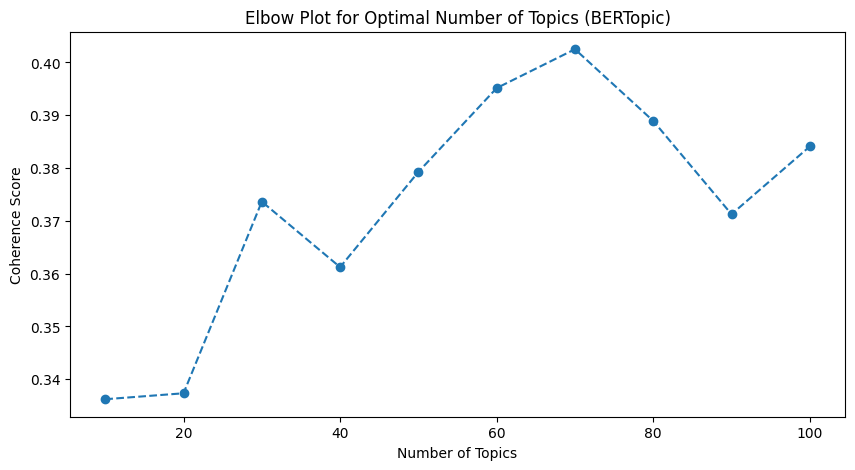

In [ ]:
# Plotting the Elbow Plot
plt.figure(figsize=(10, 5))
plt.plot(topic_numbers, coherence_scores, marker='o', linestyle='--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Elbow Plot for Optimal Number of Topics (BERTopic)')
plt.show()

In [ ]:
coherence_scores

[0.33620532161674543,
 0.3373320464976384,
 0.37363613430037257,
 0.36122450343507023,
 0.379262553891543,
 0.3951444496734647,
 0.4025058053134547,
 0.3889198267927754,
 0.3712462602678603,
 0.3840870972669378]

Based on the elbow plot, an appropriate number of topics would be 65, where the coherence score peaks before showing diminishing returns.

# Iteration 1: Remove 5%

In [ ]:
n_percent = 5
num_topics = 65
num_words = 10

# Prepare and filter documents
docs = df["content"].astype(str).tolist()
tokenized_docs = [doc.split() for doc in docs]
filtered_docs_tokens = remove_n_percent(tokenized_docs, n=n_percent)
filtered_docs = [' '.join(doc) for doc in filtered_docs_tokens]

# Load the embedding model and initialize BERTopic
embedding_model = SentenceTransformer("distilbert-base-nli-mean-tokens").to("cuda")
bert_topic = BERTopic(embedding_model=embedding_model, nr_topics=num_topics)

# Fit BERTopic to the filtered documents
topics, _ = bert_topic.fit_transform(filtered_docs)

# Calculate and print scores
print("Coherence Score:", calculate_coherence_score(filtered_docs, bert_topic, coherence_type="c_v"))
print("Diversity Score:", diversity_score(bert_topic, top_n_words=num_words))
print("Interpretability Score:", interpretability_score(bert_topic, top_n_words=num_words))

Coherence Score: 0.2735682938327791
Diversity Score: 1.0
Interpretability Score: 1.0


In [ ]:
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
topic_matrix

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1625,-1_the_to_and_of,"[the, to, and, of, in, for, on, is, that, it]",[ Thursday Market Open You sometimes hear tha...
1,0,25,0_analyst_zacks_reports_per,"[analyst, zacks, reports, per, research, and, ...",[Friday December 22 2017\nThe Zacks Research...
2,1,24,1_zacks_investment_research_or,"[zacks, investment, research, or, is, stocks, ...",[For Immediate Release\n\n\tChicago IL Apri...
3,2,12,2_missed_it_shares_earnings,"[missed, it, shares, earnings, but, years, thi...",[Earnings season isn t over yet even though mo...
4,3,17,3_investment_is_stocks_the,"[investment, is, stocks, the, zacks, of, or, f...",[For Immediate ReleaseChicago IL January 31...
5,4,32,4_zacks_the_is_investment,"[zacks, the, is, investment, stocks, for, of, ...",[For Immediate ReleaseChicago IL November 1...
6,5,18,5_research_analyst_investment_zacks,"[research, analyst, investment, zacks, is, or,...",[For Immediate ReleaseChicago IL November 27...
7,6,18,6_which_at_performers_close,"[which, at, performers, close, inc, fell, or, ...",[Investing com U S stocks were lower after ...
8,7,15,7_year_million_quarter_revenues,"[year, million, quarter, revenues, gaap, the, ...",[It has been about a month since the last earn...
9,8,13,8_lunch_dave_ryan_episode,"[lunch, dave, ryan, episode, free, zacks, toda...",[On today s episode of Free Lunch Ryan McQuee...


# Iteration 2: Remove 10%

In [ ]:
n_percent = 10
num_topics = 65
num_words = 10

# Prepare and filter documents
docs = df["content"].astype(str).tolist()
tokenized_docs = [doc.split() for doc in docs]
filtered_docs_tokens = remove_n_percent(tokenized_docs, n=n_percent)
filtered_docs = [' '.join(doc) for doc in filtered_docs_tokens]

# Load the embedding model and initialize BERTopic
embedding_model = SentenceTransformer("distilbert-base-nli-mean-tokens").to("cuda")
bert_topic = BERTopic(embedding_model=embedding_model, nr_topics=num_topics)

# Fit BERTopic to the filtered documents
topics, _ = bert_topic.fit_transform(filtered_docs)

# Calculate and print scores
print("Coherence Score:", calculate_coherence_score(filtered_docs, bert_topic, coherence_type="c_v"))
print("Diversity Score:", diversity_score(bert_topic, top_n_words=num_words))
print("Interpretability Score:", interpretability_score(bert_topic, top_n_words=num_words))

Coherence Score: 0.4244864559864063
Diversity Score: 1.0
Interpretability Score: 1.0


In [ ]:
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
topic_matrix

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1473,-1_the_to_and_of,"[the, to, and, of, in, on, that, for, is, it]",[ Friday Market Open Eight and seven Those a...
1,0,25,0_analyst_zacks_reports_per,"[analyst, zacks, reports, per, research, and, ...",[Friday December 22 2017\nThe Zacks Research...
2,1,23,1_zacks_investment_research_or,"[zacks, investment, research, or, stocks, is, ...",[For Immediate Release\n\n\tChicago IL Apri...
3,2,32,2_earnings_the_or_is,"[earnings, the, or, is, growth, in, and, of, t...",[Gone are the days when investors were content...
4,3,21,3_research_analyst_investment_is,"[research, analyst, investment, is, zacks, or,...",[For Immediate ReleaseChicago IL January 25...
5,4,31,4_is_the_investment_zacks,"[is, the, investment, zacks, of, for, stocks, ...",[For Immediate ReleaseChicago IL November 1...
6,5,12,5_investment_stocks_is_the,"[investment, stocks, is, the, zacks, of, in, f...",[For Immediate ReleaseChicago IL May 2 201...
7,6,12,6_missed_it_shares_earnings,"[missed, it, shares, earnings, but, years, thi...",[Earnings season isn t over yet even though mo...
8,7,15,7_year_million_quarter_revenues,"[year, million, quarter, revenues, gaap, the, ...",[It has been about a month since the last earn...
9,8,18,8_which_at_performers_close,"[which, at, performers, close, inc, fell, or, ...",[Investing com U S stocks were lower after ...


# Iteration 3: Remove 15%

In [ ]:
n_percent = 15
num_topics = 65
num_words = 10

# Prepare and filter documents
docs = df["content"].astype(str).tolist()
tokenized_docs = [doc.split() for doc in docs]
filtered_docs_tokens = remove_n_percent(tokenized_docs, n=n_percent)
filtered_docs = [' '.join(doc) for doc in filtered_docs_tokens]

# Load the embedding model and initialize BERTopic
embedding_model = SentenceTransformer("distilbert-base-nli-mean-tokens").to("cuda")
bert_topic = BERTopic(embedding_model=embedding_model, nr_topics=num_topics)

# Fit BERTopic to the filtered documents
topics, _ = bert_topic.fit_transform(filtered_docs)

# Calculate and print scores
print("Coherence Score:", calculate_coherence_score(filtered_docs, bert_topic, coherence_type="c_v"))
print("Diversity Score:", diversity_score(bert_topic, top_n_words=num_words))
print("Interpretability Score:", interpretability_score(bert_topic, top_n_words=num_words))

Coherence Score: 0.43080589776458367
Diversity Score: 0.9902439024390244
Interpretability Score: 0.9997432605905007


In [ ]:
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
topic_matrix

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1359,-1_the_to_and_of,"[the, to, and, of, in, that, on, for, is, it]",[ Friday Market Open If you re bullish this ...
1,0,25,0_analyst_zacks_reports_per,"[analyst, zacks, reports, per, and, research, ...",[Friday December 22 2017\nThe Zacks Research...
2,1,24,1_zacks_investment_or_research,"[zacks, investment, or, research, is, the, sto...",[For Immediate Release\n\n\tChicago IL Apri...
3,2,83,2_is_investment_the_zacks,"[is, investment, the, zacks, of, stocks, or, a...",[For Immediate ReleaseChicago IL May 15 20...
4,3,31,3_the_earnings_or_growth,"[the, earnings, or, growth, is, in, and, of, t...",[Gone are the days when investors were content...
5,4,13,4_it_shares_missed_earnings,"[it, shares, missed, earnings, target, but, th...",[Earnings season isn t over yet even though mo...
6,5,14,5_year_quarter_million_revenues,"[year, quarter, million, revenues, gaap, the, ...",[It has been about a month since the last earn...
7,6,18,6_which_at_inc_close,"[which, at, inc, close, performers, fell, or, ...",[Investing com U S stocks were lower after ...
8,7,13,7_lunch_dave_ryan_episode,"[lunch, dave, ryan, episode, free, zacks, toda...",[On today s episode of Free Lunch Ryan McQuee...
9,8,28,8_day_at40_50dma_t2108,"[day, at40, 50dma, t2108, trading, above, my, ...",[AT40 54 6 of stocks are trading above thei...


# Iteration 4: Remove: 20%

In [ ]:
n_percent = 20
num_topics = 65
num_words = 10

# Prepare and filter documents
docs = df["content"].astype(str).tolist()
tokenized_docs = [doc.split() for doc in docs]
filtered_docs_tokens = remove_n_percent(tokenized_docs, n=n_percent)
filtered_docs = [' '.join(doc) for doc in filtered_docs_tokens]

# Load the embedding model and initialize BERTopic
embedding_model = SentenceTransformer("distilbert-base-nli-mean-tokens").to("cuda")
bert_topic = BERTopic(embedding_model=embedding_model, nr_topics=num_topics)

# Fit BERTopic to the filtered documents
topics, _ = bert_topic.fit_transform(filtered_docs)

# Calculate and print scores
print("Coherence Score:", calculate_coherence_score(filtered_docs, bert_topic, coherence_type="c_v"))
print("Diversity Score:", diversity_score(bert_topic, top_n_words=num_words))
print("Interpretability Score:", interpretability_score(bert_topic, top_n_words=num_words))

Coherence Score: 0.3011087263357703
Diversity Score: 1.0
Interpretability Score: 1.0


In [ ]:
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
topic_matrix

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1613,-1_the_to_and_of,"[the, to, and, of, in, for, is, that, on, with]",[For Immediate Release\n\n\tChicago IL May ...
1,0,25,0_analyst_zacks_reports_per,"[analyst, zacks, reports, per, research, and, ...",[Friday December 22 2017\nThe Zacks Research...
2,1,11,1_missed_it_earnings_shares,"[missed, it, earnings, shares, years, but, thi...",[Earnings season isn t over yet even though mo...
3,2,19,2_zacks_investment_research_is,"[zacks, investment, research, is, stocks, or, ...",[For Immediate Release\n\n\tChicago IL Apri...
4,3,18,3_which_at_performers_close,"[which, at, performers, close, inc, fell, or, ...",[Investing com U S stocks were lower after ...
5,4,17,4_investment_is_zacks_stocks,"[investment, is, zacks, stocks, the, of, or, f...",[For Immediate ReleaseChicago IL November 1...
6,5,23,5_research_investment_zacks_analyst,"[research, investment, zacks, analyst, is, or,...",[For Immediate ReleaseChicago IL January 25...
7,6,31,6_is_the_investment_zacks,"[is, the, investment, zacks, stocks, for, of, ...",[For Immediate ReleaseChicago IL January 8 ...
8,7,13,7_lunch_dave_ryan_episode,"[lunch, dave, ryan, episode, free, zacks, toda...",[On today s episode of Free Lunch Ryan McQuee...
9,8,14,8_year_million_quarter_revenues,"[year, million, quarter, revenues, gaap, the, ...",[It has been about a month since the last earn...


# Iteration 5: number of words per topic (num_words) = 5

In [ ]:
n_percent = 15
num_topics = 65
num_words = 5

# Prepare and filter documents
docs = df["content"].astype(str).tolist()
tokenized_docs = [doc.split() for doc in docs]
filtered_docs_tokens = remove_n_percent(tokenized_docs, n=n_percent)
filtered_docs = [' '.join(doc) for doc in filtered_docs_tokens]

# Load the embedding model and initialize BERTopic
embedding_model = SentenceTransformer("distilbert-base-nli-mean-tokens").to("cuda")
bert_topic = BERTopic(embedding_model=embedding_model, nr_topics=num_topics)

# Fit BERTopic to the filtered documents
topics, _ = bert_topic.fit_transform(filtered_docs)

# Calculate and print scores
print("Coherence Score:", calculate_coherence_score(filtered_docs, bert_topic, coherence_type="c_v"))
print("Diversity Score:", diversity_score(bert_topic, top_n_words=num_words))
print("Interpretability Score:", interpretability_score(bert_topic, top_n_words=num_words))

Coherence Score: 0.4306030514205171
Diversity Score: 0.9894736842105263
Interpretability Score: 0.9996838944207366


In [ ]:
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
topic_matrix

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1424,-1_the_to_and_of,"[the, to, and, of, in, on, that, for, is, it]",[ Tuesday Market Open The question today is w...
1,0,25,0_analyst_zacks_reports_per,"[analyst, zacks, reports, per, and, research, ...",[Friday December 22 2017\nThe Zacks Research...
2,1,11,1_missed_it_earnings_shares,"[missed, it, earnings, shares, but, years, thi...",[Earnings season isn t over yet even though mo...
3,2,83,2_is_investment_the_zacks,"[is, investment, the, zacks, of, or, stocks, a...",[For Immediate ReleaseChicago IL May 15 20...
4,3,21,3_zacks_investment_research_or,"[zacks, investment, research, or, is, stocks, ...",[For Immediate Release\n\n\tChicago IL Apri...
5,4,31,4_the_earnings_or_growth,"[the, earnings, or, growth, is, in, and, of, t...",[Gone are the days when investors were content...
6,5,18,5_which_at_inc_close,"[which, at, inc, close, performers, fell, or, ...",[Investing com U S stocks were lower after ...
7,6,15,6_year_quarter_million_revenues,"[year, quarter, million, revenues, gaap, the, ...",[It has been about a month since the last earn...
8,7,14,7_lunch_dave_ryan_episode,"[lunch, dave, ryan, episode, free, zacks, why,...",[On today s episode of Free Lunch Ryan McQuee...
9,8,39,8_of_is_and_the,"[of, is, and, the, to, investment, zacks, in, ...",[For Immediate ReleaseChicago IL September ...


# Iteration 6: num_words = 15

In [ ]:
n_percent = 15
num_topics = 65
num_words = 15

# Prepare and filter documents
docs = df["content"].astype(str).tolist()
tokenized_docs = [doc.split() for doc in docs]
filtered_docs_tokens = remove_n_percent(tokenized_docs, n=n_percent)
filtered_docs = [' '.join(doc) for doc in filtered_docs_tokens]

# Load the embedding model and initialize BERTopic
embedding_model = SentenceTransformer("distilbert-base-nli-mean-tokens").to("cuda")
bert_topic = BERTopic(embedding_model=embedding_model, nr_topics=num_topics)

# Fit BERTopic to the filtered documents
topics, _ = bert_topic.fit_transform(filtered_docs)

# Calculate and print scores
print("Coherence Score:", calculate_coherence_score(filtered_docs, bert_topic, coherence_type="c_v"))
print("Diversity Score:", diversity_score(bert_topic, top_n_words=num_words))
print("Interpretability Score:", interpretability_score(bert_topic, top_n_words=num_words))

Coherence Score: 0.42004384540004025
Diversity Score: 0.6615384615384615
Interpretability Score: 0.9997869166844237


In [ ]:
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
topic_matrix

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1529,-1_the_to_of_and,"[the, to, of, and, in, for, is, on, that, it]",[ Friday Market Open If you re bullish this ...
1,0,25,0_analyst_zacks_reports_per,"[analyst, zacks, reports, per, research, and, ...",[Friday December 22 2017\nThe Zacks Research...
2,1,11,1_missed_it_earnings_shares,"[missed, it, earnings, shares, years, but, thi...",[Earnings season isn t over yet even though mo...
3,2,32,2_earnings_the_or_growth,"[earnings, the, or, growth, is, and, in, of, t...",[Gone are the days when investors were content...
4,3,23,3_investment_zacks_research_or,"[investment, zacks, research, or, stocks, is, ...",[For Immediate Release\n\n\tChicago IL Apri...
5,4,17,4_investment_is_zacks_stocks,"[investment, is, zacks, stocks, the, or, of, f...",[For Immediate ReleaseChicago IL November 2...
6,5,31,5_is_the_of_investment,"[is, the, of, investment, zacks, stocks, for, ...",[For Immediate ReleaseChicago IL November 1...
7,6,16,6_research_analyst_investment_zacks,"[research, analyst, investment, zacks, is, rep...",[For Immediate ReleaseChicago IL November 27...
8,7,18,7_which_at_performers_close,"[which, at, performers, close, inc, fell, or, ...",[Investing com U S stocks were lower after ...
9,8,14,8_lunch_dave_ryan_episode,"[lunch, dave, ryan, episode, free, zacks, why,...",[On today s episode of Free Lunch Ryan McQuee...


# Iteration 7: num_words = 20

In [ ]:
n_percent = 20
num_topics = 65
num_words = 20

# Prepare and filter documents
docs = df["content"].astype(str).tolist()
tokenized_docs = [doc.split() for doc in docs]
filtered_docs_tokens = remove_n_percent(tokenized_docs, n=n_percent)
filtered_docs = [' '.join(doc) for doc in filtered_docs_tokens]

# Load the embedding model and initialize BERTopic
embedding_model = SentenceTransformer("distilbert-base-nli-mean-tokens").to("cuda")
bert_topic = BERTopic(embedding_model=embedding_model, nr_topics=num_topics)

# Fit BERTopic to the filtered documents
topics, _ = bert_topic.fit_transform(filtered_docs)

# Calculate and print scores
print("Coherence Score:", calculate_coherence_score(filtered_docs, bert_topic, coherence_type="c_v"))
print("Diversity Score:", diversity_score(bert_topic, top_n_words=num_words))
print("Interpretability Score:", interpretability_score(bert_topic, top_n_words=num_words))

Coherence Score: 0.33725243593089166
Diversity Score: 0.5
Interpretability Score: 1.0


In [ ]:
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
topic_matrix

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1468,-1_the_to_and_of,"[the, to, and, of, in, on, that, for, is, it]",[The semiconductor industry is made up of 15 s...
1,0,25,0_analyst_zacks_reports_per,"[analyst, zacks, reports, per, and, research, ...",[Friday December 22 2017\nThe Zacks Research...
2,1,32,1_the_earnings_or_is,"[the, earnings, or, is, growth, and, in, of, t...",[Gone are the days when investors were content...
3,2,21,2_zacks_investment_research_is,"[zacks, investment, research, is, stocks, or, ...",[For Immediate Release\n\n\tChicago IL Apri...
4,3,13,3_it_shares_missed_earnings,"[it, shares, missed, earnings, target, but, th...",[Earnings season isn t over yet even though mo...
5,4,13,4_lunch_dave_ryan_episode,"[lunch, dave, ryan, episode, free, zacks, toda...",[On today s episode of Free Lunch Ryan McQuee...
6,5,20,5_research_analyst_zacks_investment,"[research, analyst, zacks, investment, is, or,...",[For Immediate ReleaseChicago IL January 25...
7,6,16,6_investment_is_zacks_stocks,"[investment, is, zacks, stocks, of, the, or, f...",[For Immediate ReleaseChicago IL November 27...
8,7,28,7_is_the_zacks_investment,"[is, the, zacks, investment, stocks, for, of, ...",[For Immediate ReleaseChicago IL November 1...
9,8,18,8_which_at_inc_close,"[which, at, inc, close, performers, fell, or, ...",[Investing com U S stocks were lower after ...
